# Using Homography for Image Registration and Alignment

We will use homography for image registration. For this, we will take an image template and align a scanned form according to the template. This will require:
* Finding keypoints and features in each image
* Matching the features and keypoints from each image
* Sorting for best matches
* Finding homography between best matches
* Aligning the scanned image

### Loading the Images

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

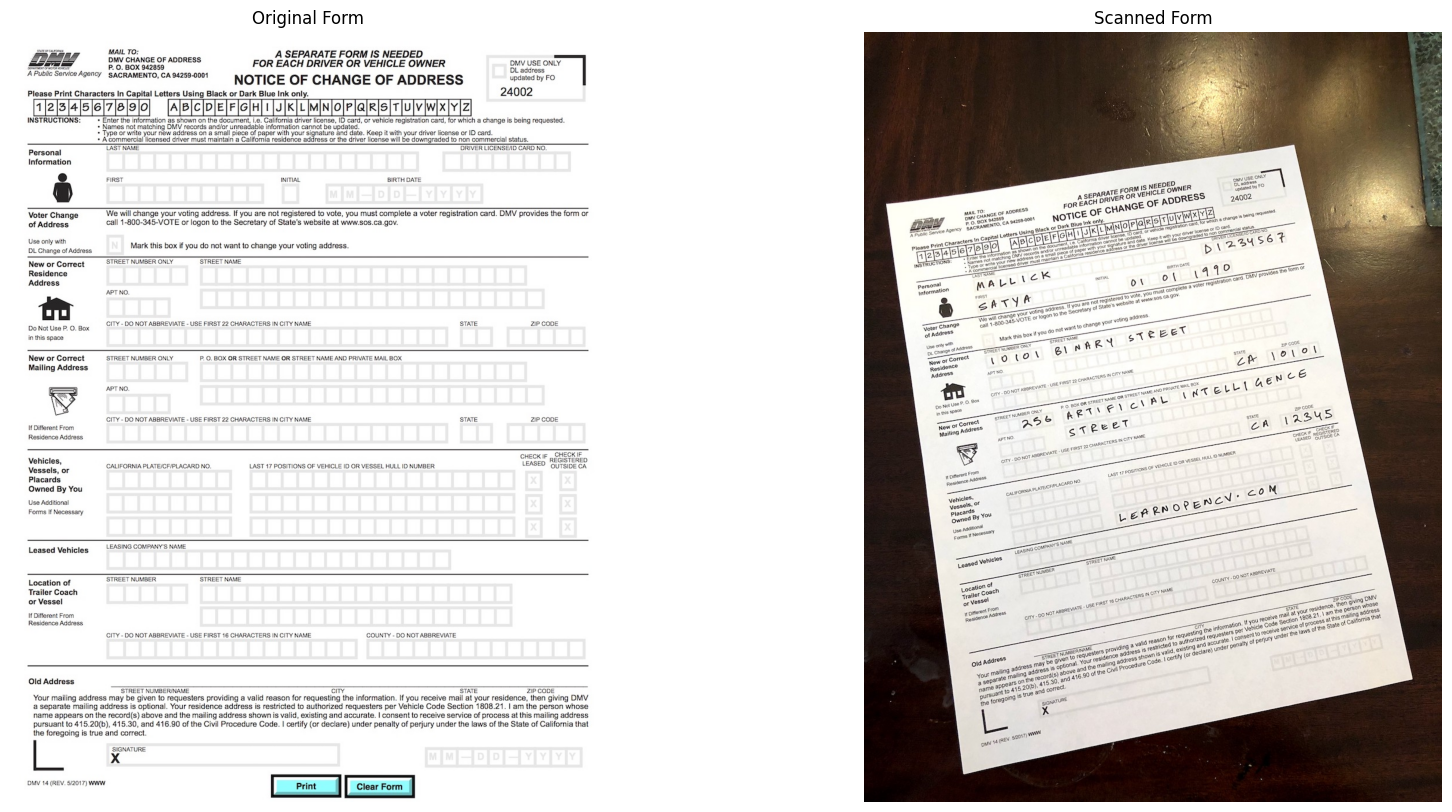

In [3]:
template = cv2.imread('images/form.jpg')
scanned = cv2.imread('images/scanned-form.jpg')

# Display the images. 
plt.figure(figsize = [20, 10])
plt.subplot(121); plt.axis('off'); plt.imshow(template[:, :, ::-1]); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(scanned[:, :, ::-1]); plt.title("Scanned Form");

Now that we have the forms, the next step is to identify the keypoints in each image, things that are unique or stand out in each image.

### Keypoint Detection

OpenCV provides many classes and algorithms for finding features. Features are elements that describe the image such as corners e.t.c. Some of them include: FAST, BRIEF, SIFT SURF, ORB and Corner detectors.

Feature detection is the task of finding these features. Once we find them, we also need to be able to describe them so that we can search for them in other images. Most of the classes described above inherit from the virtual class `features2D`. To find features, we can use the `detect` method to detect features and `compute` to describe them. Another weay to do this is to use the `detectandCompute` method.

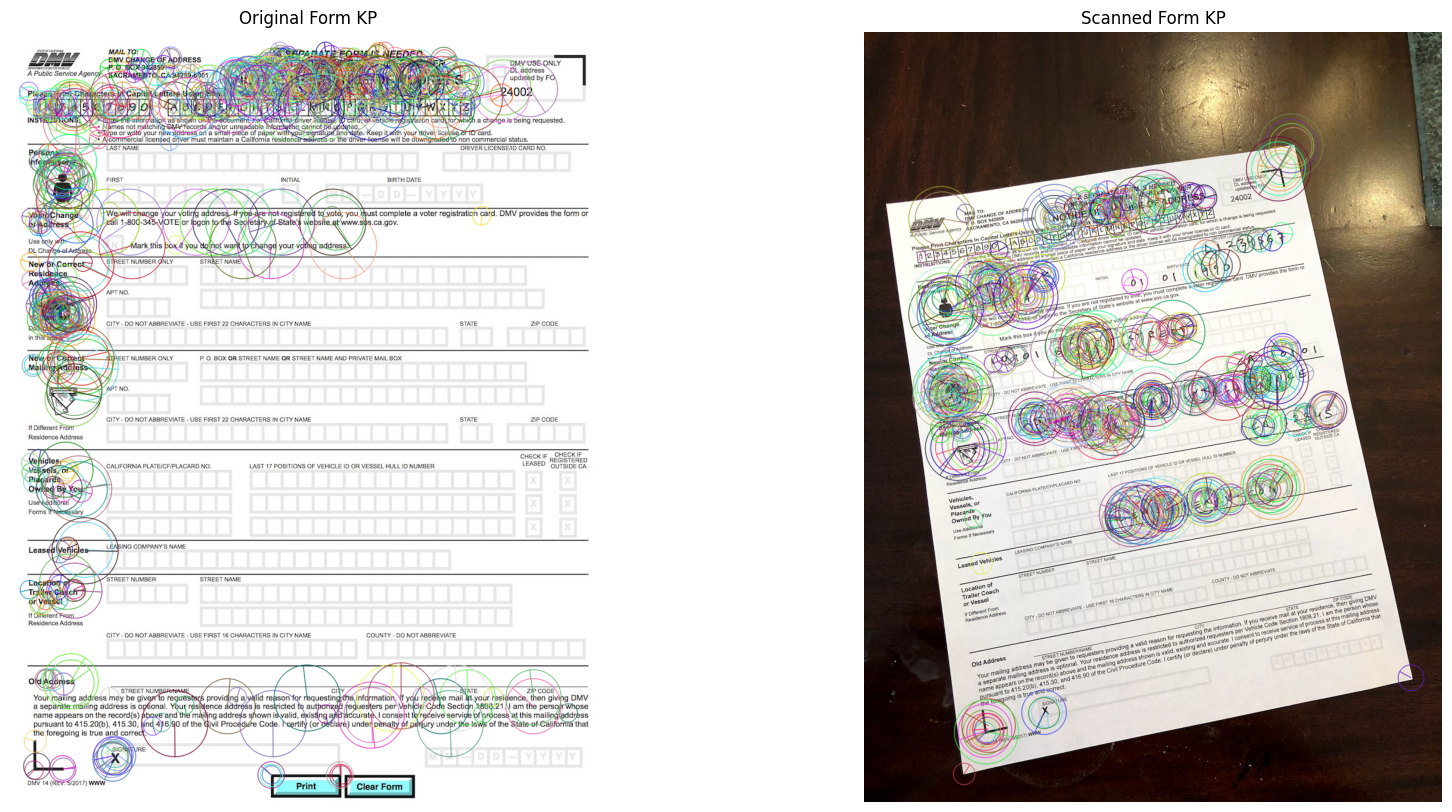

In [19]:
# we will use ORB
#creating an ORB object
orb_object = cv2.ORB_create(nfeatures=600)

keypoints1, descriptors1 = orb_object.detectAndCompute(template, None)
keypoints2, descriptors2 = orb_object.detectAndCompute(scanned, None)

#We can drawn the keypoints
template_keypoints = cv2.drawKeypoints(template, keypoints1, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
scanned_keypoints = cv2.drawKeypoints(scanned, keypoints2, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the keypoint images. 
plt.figure(figsize = [20, 10])
plt.subplot(121); plt.axis('off'); plt.imshow(template_keypoints[:, :, ::-1]); plt.title("Original Form KP")
plt.subplot(122); plt.axis('off'); plt.imshow(scanned_keypoints[:, :, ::-1]); plt.title("Scanned Form KP");

### Examining Keypoints and Descriptors

In [23]:
print(type(keypoints1))
print(type(keypoints1[0]))
print(len(keypoints1))

<class 'tuple'>
<class 'cv2.KeyPoint'>
600


We see that the keypoints are a tuple of keypoints of the size `nfeatures`. Each keypoint is an object of the class `cv.Keypoint` whose atrributes include angle, pt (x, y coordinate of position in image) and size (of neighborhood).

In [28]:
print('Orientation', keypoints1[0].angle)
print('X = ', keypoints1[0].pt[0], ' Y = ', keypoints1[0].pt[1])
print('Size = ', keypoints1[0].size)

Orientation 269.11480712890625
X =  587.0  Y =  75.0
Size =  31.0


In [33]:
print(type(descriptors1))
print(descriptors1.shape)

<class 'numpy.ndarray'>
(600, 32)


The descriptors a simply an array of arrays of the same length as the descriptors and 32 descriptions in this case. 

Now that we have the keypoints and descriptors for each image, we can go on and match them up.

### Feature Matching

We will use the brute-force matcher. More details [here](https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html). We can call the method directly from the class `BFMatcher` or use the parent class `DescriptorMatcher` which creates either a Flann-based of BF matcher object.

In [36]:
# creating the object
matcher = cv2.BFMatcher.create(cv2.NORM_HAMMING, True)

#using our matcher object to match
matches_normal = matcher.match(descriptors1, descriptors2)

In [43]:
type(matches_normal[0])

cv2.DMatch

The `match` method returns a tuple of `DMatch` objects each of which contain: (distance) the distance between descriptors, imgIdx (train image index), queryIdx (query descriptor index) and trainIdx (train descriptor index). We can sort the matches according to distance and only keep a portion.

In [54]:
matches_normal = sorted(matches_normal, key=lambda x:x.distance, reverse=False)
matches_normal = matches_normal[:int(len(matches_normal) * .1)]

Drawing the matches.

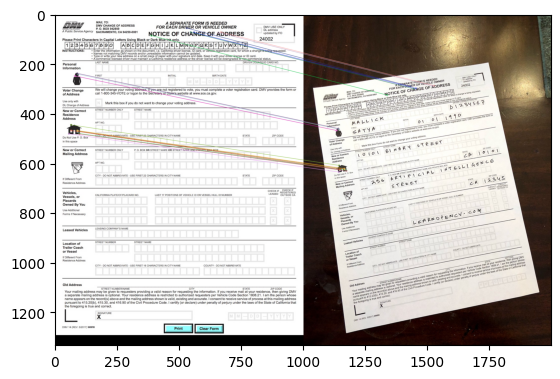

In [60]:
drawn_matches = cv2.drawMatches(
            template,
            keypoints1,
            scanned,
            keypoints2,
            matches_normal,
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(drawn_matches[:, :, ::-1])

### Using Homography to align scanned image

We compute the homographies of the best descriptors of the image.

In [63]:
# Extract the location of good matches.
points1 = np.zeros((len(matches_normal), 2), dtype = np.float32)
points2 = np.zeros((len(matches_normal), 2), dtype = np.float32)

for i, match in enumerate(matches_normal):
    points1[i] = keypoints1[match.queryIdx].pt
    points2[i] = keypoints2[match.trainIdx].pt

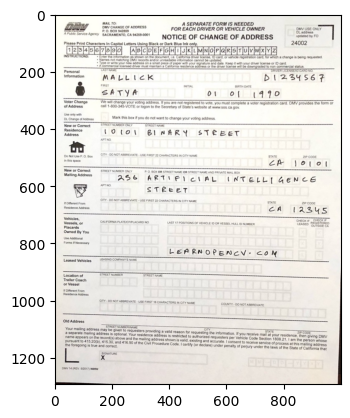

In [66]:
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
height, width = template.shape[:2]
scanned_restored = cv2.warpPerspective(scanned, h, (width, height))

plt.imshow(scanned_restored[:, :, ::-1])